In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import cv2
from string import punctuation
from wordcloud import WordCloud, STOPWORDS
import os
import itertools
import xml.etree.ElementTree as ET

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive

Mounted at /content/drive
/content/drive


**Extracting Images and Findings from Data**

In [24]:
#Function will take root directory as input and returns images and findings
def xml_report_generation(dir):
  findings_report = []
  parentImages = []
  #Iterate over root directory
  for root,directory,files in os.walk(dir):
    for file in files:
      #To parse xml data
      xml = ET.parse(root+'/'+file)
      #Retrieve root element
      root_element = xml.getroot()
      #Iterate over child elemets to retrieve findings
      for child in root_element.find('MedlineCitation/Article/Abstract'):
        for val in child.attrib.values():
          if val == 'FINDINGS':
            findings_report.append(child.text)

      imageList = []
      #Iterate over child elemets to retrieve images
      for child in root_element.findall('parentImage'):
        for val in child.attrib.values():
          imageList.append(val)
      parentImages.append(imageList)
  
  return findings_report,parentImages

In [25]:
findings , images = xml_report_generation('/content/drive/My Drive/CS2/Data-cs2/NLMCXR_reports/')

In [26]:
extracted_data = pd.DataFrame(columns=['Findings','Images'])
extracted_data['Findings'] = findings
extracted_data['Images'] = images
extracted_data.head(5)

,Findings,Images
0,Heart size upper normal but stable. Mediastina...,"[CXR567_IM-2167-1001, CXR567_IM-2167-2001]"
1,None,"[CXR546_IM-2150-1001, CXR546_IM-2150-2001]"
2,Normal heart. Calcified right hilar granulomas...,"[CXR516_IM-2130-1001, CXR516_IM-2130-2001]"
3,"No pneumothorax, pleural effusion or airspace ...","[CXR519_IM-2131-1001, CXR519_IM-2131-2001, CXR..."
4,Heart size normal. Lungs are clear. XXXX are n...,[CXR523_IM-2134-2001]


There are 3955 xnl files are there in dataset,  I have extracted those using element tree parser and retrieved FINDINGS and Images.

Each xml contains one findings and images.


**Removing empty values in Images and Findings**

In [27]:
print(extracted_data.shape)
#Checking if there are any missing values in Images or not
extracted_data = extracted_data[extracted_data["Images"].str.len() != 0]
print(extracted_data.shape)
#Checking if there are any missing values in Findings or not
extracted_data = extracted_data[extracted_data["Findings"].isnull() != True]
print(extracted_data.shape)

(3955, 2)
(3851, 2)
(3337, 2)


Number of rows contais empty images : 104

Number of rows contains empty findings : 514

Removed 618 rows from dataset

In [28]:
extracted_data.head(5)

,Findings,Images
0,Heart size upper normal but stable. Mediastina...,"[CXR567_IM-2167-1001, CXR567_IM-2167-2001]"
2,Normal heart. Calcified right hilar granulomas...,"[CXR516_IM-2130-1001, CXR516_IM-2130-2001]"
3,"No pneumothorax, pleural effusion or airspace ...","[CXR519_IM-2131-1001, CXR519_IM-2131-2001, CXR..."
4,Heart size normal. Lungs are clear. XXXX are n...,[CXR523_IM-2134-2001]
5,The lungs are clear without evidence of focal ...,"[CXR547_IM-2151-1001, CXR547_IM-2151-2001]"


**Image Data Analysis**

In [29]:
#Min and Max no of images few findings contains one image and few are morethan one.
print(extracted_data["Images"].str.len().min(),extracted_data["Images"].str.len().max())

1 5


In [30]:
#Creatd new colunmn Imagecount which contains no of images per person
extracted_data['ImageCount'] = extracted_data["Images"].str.len()

In [31]:
extracted_data.head(5)

,Findings,Images,ImageCount
0,Heart size upper normal but stable. Mediastina...,"[CXR567_IM-2167-1001, CXR567_IM-2167-2001]",2
2,Normal heart. Calcified right hilar granulomas...,"[CXR516_IM-2130-1001, CXR516_IM-2130-2001]",2
3,"No pneumothorax, pleural effusion or airspace ...","[CXR519_IM-2131-1001, CXR519_IM-2131-2001, CXR...",3
4,Heart size normal. Lungs are clear. XXXX are n...,[CXR523_IM-2134-2001],1
5,The lungs are clear without evidence of focal ...,"[CXR547_IM-2151-1001, CXR547_IM-2151-2001]",2


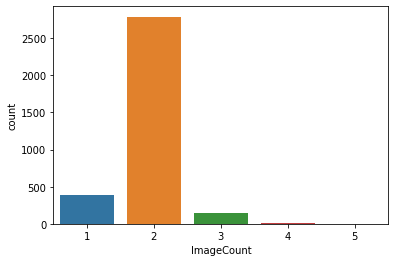

In [32]:
sns.countplot(x ='ImageCount', data = extracted_data)

As we can see there are multiple images corresponding to a single person. These are different chest scans at different views. Most of the individuals have only 2 scans while the highest being 5.

**Frontal and Lateral images of same report**

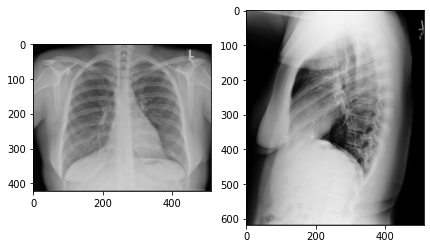

In [35]:
plt.figure(figsize=(7,7))
plt.subplot(121)
frontal = cv2.imread('/content/drive/My Drive/CS2/Data-cs2/NLMCXR_png/CXR558_IM-2158-0001-0001.png')
plt.imshow(frontal)
plt.subplot(122)
lateral = cv2.imread('/content/drive/My Drive/CS2/Data-cs2/NLMCXR_png/CXR558_IM-2158-0001-0002.png')
plt.imshow(lateral)

Images heights and widths are different we have to reshape all images to fixed size

**Cleaning Text(Findings) Data**

In [36]:
def convertToLowerCase(report):
  return ' '.join(word.lower() for word in report.split(' '))

# Punctations: '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
def removePunctations(report):
  return ''.join(word for word in report if word not in punctuation)

def removeHtmlTags(report):
  new_report = re.sub('<[^<]+?>','', report)
  return new_report

def removeNumbers(report):
  return ' '.join(word for word in report.split(' ') if not word.isdigit())

def removeXXX(report):
  return ' '.join(re.sub('x*','',word) for word in report.split(' '))

def decontracted(report):
  report = re.sub("won\'t", "will not", report)
  report = re.sub("can\'t", "can not", report)
  report = re.sub("couldn\'t", "could not", report)
  report = re.sub("shouldn\'t", "should not", report)
  report = re.sub("wouldn\'t", "would not", report)
  report = re.sub("n\'t", " not", report)
  report = re.sub("\'re", " are", report)
  report = re.sub("\'s", " is", report)
  report = re.sub("\'d", " would", report)
  report = re.sub("\'ll", " will", report)
  report = re.sub("\'t", " not", report)
  report = re.sub("\'ve", " have", report)
  report = re.sub("\'m", " am", report)
  return report

def removeFullStops(report):
  return ' '.join(re.sub('\.', '', word) for word in report.split(' '))

def removeMultipleSpaces(report):
  return ' '.join(word for word in report.split())

Removed all special characters , numbers , decontractions, multiple spaces and full stops from findings using above functions

In [41]:
def preprocessTextFeature(report):
  report = convertToLowerCase(report)
  report = removePunctations(report)
  report = removeHtmlTags(report)
  report = removeXXX(report)
  report = decontracted(report)
  report = removeFullStops(report)
  report = removeMultipleSpaces(report)
  report = removeNumbers(report)
  return report

In [42]:
cleaned_findings = []
for report in extracted_data['Findings']:
  cleaned_findings.append(preprocessTextFeature(report))

# created new column and assigned findngs after cleaning
extracted_data['Cleaned_Findings'] = cleaned_findings
extracted_data.head(5)

,Findings,Images,ImageCount,Cleaned_Findings
0,Heart size upper normal but stable. Mediastina...,"[CXR567_IM-2167-1001, CXR567_IM-2167-2001]",2,heart size upper normal but stable mediastinal...
2,Normal heart. Calcified right hilar granulomas...,"[CXR516_IM-2130-1001, CXR516_IM-2130-2001]",2,normal heart calcified right hilar granulomas ...
3,"No pneumothorax, pleural effusion or airspace ...","[CXR519_IM-2131-1001, CXR519_IM-2131-2001, CXR...",3,no pneumothora pleural effusion or airspace co...
4,Heart size normal. Lungs are clear. XXXX are n...,[CXR523_IM-2134-2001],1,heart size normal lungs are clear are normal n...
5,The lungs are clear without evidence of focal ...,"[CXR547_IM-2151-1001, CXR547_IM-2151-2001]",2,the lungs are clear without evidence of focal ...


**Creating pairs of images**

In [45]:
def pairsOfImages(data):
  image_frontal = []
  images_lateral = []
  findings = []
  images_list = list(data['Images'])
  findings_list = list(data['Cleaned_Findings'])
  #Iterate over imagecount values to create pairs of images
  for index,count in enumerate(data['ImageCount'].values):
    #If report contains one image we have to give same image as a frontal and lateral
    if count == 1:
      image_frontal.extend(images_list[index])
      images_lateral.extend(images_list[index])
      findings.append(findings_list[index])
    else:
      #simplify combinatorial constructs such as permutations, combinations, and Cartesian products
      prob_images  = itertools.combinations(images_list[index], 2)
      for image in prob_images:
        image_frontal.append(image[0])
        images_lateral.append(image[1])
        findings.append(findings_list[index])
  
  return image_frontal , images_lateral , findings

In [46]:
frontal , lateral ,findings = pairsOfImages(extracted_data)
#created datframe after creating pairs of images
final_data = pd.DataFrame(columns=['Frontal','Lateral','Findings'])
final_data = final_data.assign(Frontal=frontal,Lateral=lateral,Findings=findings)
final_data.head(5)

,Frontal,Lateral,Findings
0,CXR567_IM-2167-1001,CXR567_IM-2167-2001,heart size upper normal but stable mediastinal...
1,CXR516_IM-2130-1001,CXR516_IM-2130-2001,normal heart calcified right hilar granulomas ...
2,CXR519_IM-2131-1001,CXR519_IM-2131-2001,no pneumothora pleural effusion or airspace co...
3,CXR519_IM-2131-1001,CXR519_IM-2131-4001,no pneumothora pleural effusion or airspace co...
4,CXR519_IM-2131-2001,CXR519_IM-2131-4001,no pneumothora pleural effusion or airspace co...


we have multiple chest scans to produce a single report. Some person_ids have 1, some have 2 and the highest is 4. So we can take pairs of those images as input.

In [47]:
final_data.to_csv('/content/drive/My Drive/CS2/final.csv')

**Creating Word Cloud On Findings After Cleaning**

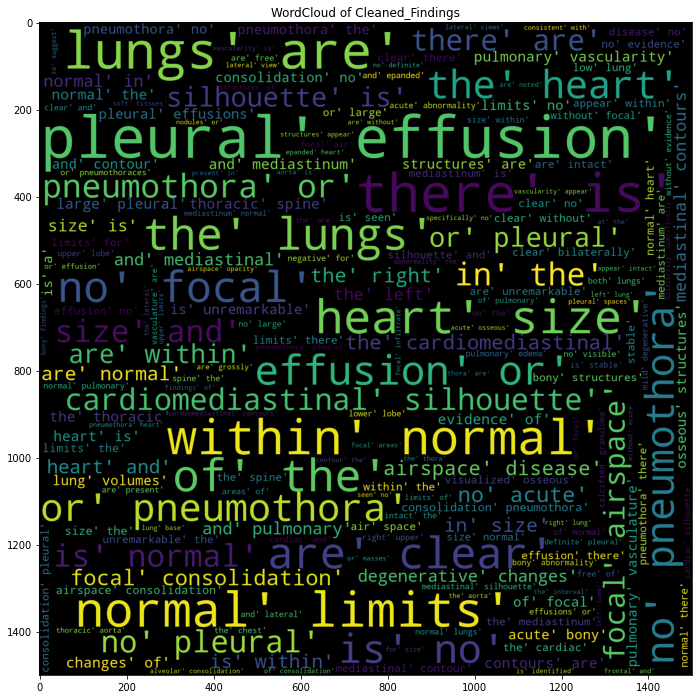

In [63]:
word_generators = []
#Iterate over findings and split them
for report in final_data['Findings']:
    word_generators.extend(report.split())
  
word_cloud = WordCloud(height=1500, width=1500,background_color ='black').generate(str(word_generators))
plt.figure(figsize=(12,12))
plt.title('WordCloud of Cleaned_Findings')
plt.imshow(word_cloud)

**Top 50 Words based on IDF score**

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfIdf = TfidfVectorizer()
model_fit = tfIdf.fit(final_data['Findings'])

In [60]:
idf_scores = list(model_fit.idf_)
words = list(model_fit.get_feature_names())
[words[index] for index in  list(np.argsort(idf_scores))[:50:]]

['normal',
 'no',
 'the',
 'pleural',
 'are',
 'pneumothora',
 'or',
 'effusion',
 'is',
 'heart',
 'and',
 'size',
 'lungs',
 'focal',
 'of',
 'clear',
 'within',
 'limits',
 'there',
 'in',
 'pulmonary',
 'consolidation',
 'silhouette',
 'airspace',
 'cardiomediastinal',
 'mediastinal',
 'right',
 'acute',
 'left',
 'lung',
 'mediastinum',
 'spine',
 'disease',
 'structures',
 'with',
 'unremarkable',
 'contours',
 'changes',
 'bony',
 'contour',
 'stable',
 'thoracic',
 'degenerative',
 'large',
 'without',
 'mild',
 'seen',
 'osseous',
 'opacity',
 'cardiac']